# ACOL replication tensorflow

## Setup stuff

In [1]:
#imports and settings:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#from jupyterthemes import jtplot
from sklearn.cluster import KMeans
from scipy.stats import threshold
#jtplot.style()
%matplotlib inline
tf.logging.set_verbosity(tf.logging.INFO)
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)

Extracting ./MNIST_data\train-images-idx3-ubyte.gz
Extracting ./MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data\t10k-labels-idx1-ubyte.gz


In [2]:
clustCount = 5
classCount = 2
net = 0
trainsteps = 50000
trainsteps = 30000
perc = 1.0

## Network helper functions

In [3]:
#helper funcs
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def matrix_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    return tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)

def avg_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    totalSoft = tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)
    return tf.reduce_sum(totalSoft,2)

def max_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    totalSoft = tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)
    return tf.reduce_max(totalSoft,2)

def initACOL(in_size,clust,clss):
    acolLayers = []
    for i in range(clss):
        acolLayers.append([
            weight_variable([in_size, clustCount]),
            bias_variable([clustCount])
        ])
    return acolLayers
        
def connectACOL(inLayer,acol):
    clust = []
    for l in range(0,len(acol)):
        clust.append(tf.matmul(inLayer, acol[l][0]) + acol[l][1])
    return clust
        
def acol(input,clust_count, class_count):
    acolLayers = []
    for i in range(class_count):
        if isinstance(input, tuple):
                input = input[0]

        #I don't know what this bit does, but I don't think it'll hurt anything
        #Or maybe it does, who knows
        input_shape = input.get_shape()
        if input_shape.ndims == 4:
            dim = 1
            for d in input_shape[1:].as_list():
                dim *= d
        #    feed_in = tf.reshape(tf.transpose(input,[0,3,1,2]), [-1, dim])
        else:
            feed_in, dim = (input, int(input_shape[-1]))

        init_weights = tf.truncated_normal_initializer(0.0, stddev=0.1)#(0.0, stddev=0.01)
        init_biases = tf.constant_initializer(1.0)#(0.1)

        weights = weight_variable([dim, clust_count])
        biases = bias_variable([clust_count])

        acoll = tf.nn.xw_plus_b(input,weights,biases)
        acolLayers.append(acol)
    return acolLayers    


## Create placeholders (weights&biases)

In [4]:
if net==0:
    #Init model weights & biases
    sess = tf.InteractiveSession()

    x = tf.placeholder(tf.float32, shape=[None, 784])
    x_image = tf.reshape(x, [-1,28,28,1])
    y_ = tf.placeholder(tf.float32, shape=[None, classCount])
    y2_ = tf.placeholder(tf.float32, shape=[None,classCount,clustCount])
    
    #conv_layer1
    W_conv1 = weight_variable([5,5,1,32])
    b_conv1 = bias_variable([32])

    #conv_layer2
    W_conv2 = weight_variable([5,5,32,64])
    b_conv2 = bias_variable([64])

    #fc layer 1
    W_fc1 = weight_variable([7*7*64, 1024])
    b_fc1 = bias_variable([1024])

    acol = initACOL(1024,clustCount,classCount)

    #final fc layer
    W_fc2 = weight_variable([1024, classCount])
    b_fc2 = bias_variable([classCount])

### Define network

In [5]:
if net==0:
    dropout=0.3
    #Define net
    #conv 1
    l_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    l_pool1 = max_pool_2x2(l_conv1)

    #conv 2
    l_conv2 = tf.nn.relu(conv2d(l_pool1, W_conv2) + b_conv2)
    l_pool2 = max_pool_2x2(l_conv2)

    #fc 1
    l_pool2_flat = tf.reshape(l_pool2, [-1, 7*7*64])
    l_fc1 = tf.nn.relu(tf.matmul(l_pool2_flat, W_fc1) + b_fc1)

    l_fc1_drop = tf.nn.dropout(l_fc1, tf.constant(dropout))

    l_acol = connectACOL(l_fc1_drop,acol)
    #l_acol = acol(l_fc1_drop,clustCount,classCount)

    #Classification layer
    stackedClusts = tf.stack(l_acol,1)
    softmaxMat = matrix_softmax(stackedClusts)
    smStacked = tf.reduce_max(softmaxMat,2)

    y_conv = smStacked

## Paper architecture

In [6]:
if net==1:
    #Init model weights & biases
    sess = tf.InteractiveSession()

    x = tf.placeholder(tf.float32, shape=[None, 784])
    x_image = tf.reshape(x, [-1,28,28,1])
    y_ = tf.placeholder(tf.float32, shape=[None, classCount])
    y2_ = tf.placeholder(tf.float32, shape=[None,classCount,clustCount])
    
    #keep_prob = tf.placeholder(tf.float32)

    #conv_layer1
    W_conv1 = weight_variable([3,3,1,32])
    b_conv1 = bias_variable([32])

    #conv_layer2
    W_conv2 = weight_variable([3,3,32,32])
    b_conv2 = bias_variable([32])

    #conv_layer3
    W_conv3 = weight_variable([3,3,32,64])
    b_conv3 = bias_variable([64])

    #conv_layer4
    W_conv4 = weight_variable([3,3,64,64])
    b_conv4 = bias_variable([64])

    #fc layer 1
    W_fc1 = weight_variable([7*7*64, 2048])
    b_fc1 = bias_variable([2048])

    #acol = initACOL(2048,clustCount,classCount)

In [7]:
if net==1:
    #Define net
    #conv 1
    l_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    #conv 2
    l_conv2 = tf.nn.relu(conv2d(l_conv1, W_conv2) + b_conv2)
    l_pool2 = max_pool_2x2(l_conv2)

    l_drop1 = tf.nn.dropout(l_pool2, tf.constant(0.25))

    #conv 3
    l_conv3 = tf.nn.relu(conv2d(l_drop1, W_conv3) + b_conv3)
    #conv 4
    l_conv4 = tf.nn.relu(conv2d(l_conv3, W_conv4) + b_conv4)
    l_pool4 = max_pool_2x2(l_conv4)

    l_drop2 = tf.nn.dropout(l_pool4, tf.constant(0.25))

    #fc 1
    l_pool2_flat = tf.reshape(l_drop2, [-1, 7*7*64])

    l_fc1 = tf.nn.relu(tf.matmul(l_pool2_flat, W_fc1) + b_fc1)
    
    l_fc1_drop = tf.nn.dropout(l_fc1, tf.constant(0.5))
    
    #l_acol = connectACOL(l_fc1_drop,acol)
    l_acol = acol(l_fc1_drop,clustCount, classCount)

    #Classification layer
    stackedClusts = tf.stack(l_acol,1)
    softmaxMat = matrix_softmax(stackedClusts)
    smStacked = tf.reduce_max(softmaxMat,2)

    y_conv = smStacked

## Helperfunctions for loss

In [8]:
#helper loss funcs
def zBar(x):
    xshape = x.shape.as_list()
    s=[-1,xshape[1]*xshape[2]]
    return tf.maximum(tf.reshape(x,s),0)
    
def bigU(zb):
    return tf.matmul(tf.transpose(zb),zb)

def selectNonDiag(x):
    selection = np.ones(x.shape.as_list()[0],dtype='float32') - np.eye(x.shape.as_list()[0],dtype='float32')
    return tf.reduce_sum(tf.multiply(x,selection))

def bigV(x):
    smallNu=tf.reshape(tf.reduce_sum(x,axis=0),[1,-1])
    return tf.multiply(tf.transpose(smallNu),smallNu)

def specialNormalise(x):
    top = selectNonDiag(x)
    bottom = tf.multiply(tf.to_float(x.shape[1]-1),tf.reduce_sum(tf.multiply(x,np.eye(x.shape[1],dtype='float32'))))
    return tf.divide(top,bottom)

def frobNorm(x):
    return tf.sqrt(tf.reduce_sum(tf.square(x)))

tresh = tf.constant(0.03)
cc0=1.0
cc1=1.0
cc2=1.0
cc3=0.0003
cc4=0.000001
cc5=1.0
c0 = tf.constant(cc0)
c1 = tf.constant(cc1)
c2 = tf.constant(cc2)
c3val = tf.constant(cc3)
c3 = lambda affinity: tf.cond(tf.less(affinity,tresh),lambda: c3val,lambda: tf.constant(0.0))
c4 =tf.constant(cc4)
c5 = tf.constant(cc5)

### Calculate loss

In [9]:
#calculate losses
#affinity
bZ = zBar(stackedClusts)#softmaxMat)
bU = bigU(bZ)
coact = selectNonDiag(bU)
affinity = specialNormalise(bU)

#balance
bV=bigV(bZ)
balance = specialNormalise(bV)

#cluster cross entropy (added if secondary label is set for that input, hard to do with batches?)
clust_cross_entropy = tf.reduce_mean(-tf.reduce_sum(y2_ * tf.log(tf.clip_by_value(softmaxMat,1e-10,1.0)), reduction_indices=[1,2]))

#cross entropy
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.clip_by_value(y_conv,1e-10,1.0)), reduction_indices=[1]))

frob = frobNorm(stackedClusts)#softmaxMat)

loss = c0*cross_entropy + c5*clust_cross_entropy + c1*affinity + c2*tf.subtract(tf.constant(1.0),balance) + c3(affinity)*coact + c4*frob

## Train network

In [10]:
lr = 1e-5
train_step = tf.train.AdamOptimizer(lr).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

In [11]:
#y = {0:[0,1], 1:[1,0]}
y = {0:[1,0,0,0,0],
     1:[1,0,0,0,0],
     2:[0,1,0,0,0],
     3:[0,1,0,0,0],
     4:[0,0,1,0,0],
     5:[0,0,1,0,0],
     6:[0,0,0,1,0],
     7:[0,0,0,1,0],
     8:[0,0,0,0,1],
     9:[0,0,0,0,1]}

y = {0:[1,0],
     1:[1,0],
     2:[1,0],
     3:[1,0],
     4:[1,0],
     5:[0,1],
     6:[0,1],
     7:[0,1],
     8:[0,1],
     9:[0,1]}

y2 = {
    0:np.zeros((classCount,clustCount)),
    1:np.zeros((classCount,clustCount)),
    2:np.zeros((classCount,clustCount)),
    3:np.zeros((classCount,clustCount)),
    4:np.zeros((classCount,clustCount)),
    5:np.zeros((classCount,clustCount)),
    6:np.zeros((classCount,clustCount)),
    7:np.zeros((classCount,clustCount)),
    8:np.zeros((classCount,clustCount)),
    9:np.zeros((classCount,clustCount))
}

y2[0][0,0] = 1
y2[1][0,1] = 1
y2[2][0,2] = 1
y2[3][0,3] = 1
y2[4][0,4] = 1
y2[5][1,0] = 1
y2[6][1,1] = 1
y2[7][1,2] = 1
y2[8][1,3] = 1
y2[9][1,4] = 1

emptyy2 = {
    0:np.zeros((classCount,clustCount)),
    1:np.zeros((classCount,clustCount)),
    2:np.zeros((classCount,clustCount)),
    3:np.zeros((classCount,clustCount)),
    4:np.zeros((classCount,clustCount)),
    5:np.zeros((classCount,clustCount)),
    6:np.zeros((classCount,clustCount)),
    7:np.zeros((classCount,clustCount)),
    8:np.zeros((classCount,clustCount)),
    9:np.zeros((classCount,clustCount))
}

totalSteps = trainsteps
stepCount=0
batchSize = 128
hist = {
    'train_acc':[],
    'val_acc':[],
    'train_loss':[],
    'val_loss':[],
    'affinity':[],
    'balance':[],
    'coactivity':[]
}

In [12]:
convy2 = y2
for i in range(totalSteps):
    if i > totalSteps*perc:
       convy2 = emptyy2
        
    trainbatch = mnist.train.next_batch(batchSize)
    trainbatch = (trainbatch[0],np.array([y[np.argmax(trainbatch[1][j])] for j in range(len(trainbatch[1]))]),np.array([convy2[np.argmax(trainbatch[1][j])] for j in range(len(trainbatch[1]))]))
    valbatch = mnist.validation.next_batch(batchSize)
    valbatch = (valbatch[0],np.array([y[np.argmax(valbatch[1][j])] for j in range(len(valbatch[1]))]),np.array([convy2[np.argmax(valbatch[1][j])] for j in range(len(valbatch[1]))]))
    
    if i%100 == 0:
        train_loss,train_acc = sess.run([loss, accuracy],feed_dict={x: trainbatch[0], y_: trainbatch[1], y2_: trainbatch[2]})
        val_loss, val_acc = sess.run([loss, accuracy],feed_dict={x: valbatch[0], y_: valbatch[1], y2_: valbatch[2]})
        hist['train_acc'].append(train_acc)
        hist['val_acc'].append(val_acc)
        hist['train_loss'].append(train_loss)
        hist['val_loss'].append(val_loss)
        print("step %d/%d \n Train: accuracy: %g, loss: %g \n Validation: accuracy: %g loss: %g"%(i,totalSteps, train_acc, train_loss, val_acc, val_loss))
        hist['affinity'].append(affinity.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1], y2_: trainbatch[2]}))
        hist['balance'].append(balance.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1], y2_: trainbatch[2]}))
        hist['coactivity'].append(coact.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1], y2_: trainbatch[2]}))
        entr = cross_entropy.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1], y2_: trainbatch[2]})
        entr2 = clust_cross_entropy.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1], y2_: trainbatch[2]})
        frb = frob.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1], y2_: trainbatch[2]})
        
        #print bV.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]})
        
        print(" cross_entropy: %g, clust_cross_entropy: %g, affinity: %g, balance: %g, coact: %g, frob: %g"%(cc0*entr, cc5*entr2 ,cc1*hist['affinity'][-1],cc2*(1-hist['balance'][-1]),cc3*hist['coactivity'][-1],cc4*frb))
    feed_dict = {x: trainbatch[0], y_: trainbatch[1], y2_: trainbatch[2]}
    _ = sess.run([train_step],feed_dict=feed_dict)

step 0/30000 
 Train: accuracy: 0.4375, loss: 18.3746 
 Validation: accuracy: 0.523438 loss: 18.0275
 cross_entropy: 2.82729, clust_cross_entropy: 14.4928, affinity: 0.326227, balance: 0.275942, coact: 55.1381, frob: 0.00037842
step 100/30000 
 Train: accuracy: 0.546875, loss: 12.7881 
 Validation: accuracy: 0.507812 loss: 13.206
 cross_entropy: 2.2216, clust_cross_entropy: 9.84717, affinity: 0.283964, balance: 0.0257844, coact: 20.4212, frob: 0.0002726
step 200/30000 
 Train: accuracy: 0.546875, loss: 8.88692 
 Validation: accuracy: 0.53125 loss: 9.10301
 cross_entropy: 2.03384, clust_cross_entropy: 6.91149, affinity: 0.264668, balance: 0.0248508, coact: 10.6162, frob: 0.000213981
step 300/30000 
 Train: accuracy: 0.632812, loss: 6.3056 
 Validation: accuracy: 0.539062 loss: 6.94285
 cross_entropy: 1.67698, clust_cross_entropy: 5.30495, affinity: 0.233768, balance: 0.0269358, coact: 6.9324, frob: 0.000197097
step 400/30000 
 Train: accuracy: 0.671875, loss: 5.56148 
 Validation: accur

step 3500/30000 
 Train: accuracy: 0.890625, loss: 1.28138 
 Validation: accuracy: 0.9375 loss: 0.886115
 cross_entropy: 0.416389, clust_cross_entropy: 0.610752, affinity: 0.0616654, balance: 0.0315585, coact: 0.993273, frob: 0.000144334
step 3600/30000 
 Train: accuracy: 0.945312, loss: 0.688464 
 Validation: accuracy: 0.898438 loss: 0.944998
 cross_entropy: 0.26047, clust_cross_entropy: 0.406158, affinity: 0.0816054, balance: 0.034685, coact: 0.954507, frob: 0.000137502
step 3700/30000 
 Train: accuracy: 0.945312, loss: 0.836281 
 Validation: accuracy: 0.953125 loss: 0.714395
 cross_entropy: 0.169566, clust_cross_entropy: 0.3314, affinity: 0.0704448, balance: 0.0513557, coact: 0.988486, frob: 0.000147415
step 3800/30000 
 Train: accuracy: 0.9375, loss: 1.06228 
 Validation: accuracy: 0.921875 loss: 0.662065
 cross_entropy: 0.327652, clust_cross_entropy: 0.517623, affinity: 0.0799147, balance: 0.0400459, coact: 0.955011, frob: 0.000136113
step 3900/30000 
 Train: accuracy: 0.953125, l

 cross_entropy: 0.125744, clust_cross_entropy: 0.213555, affinity: 0.0495161, balance: 0.0624495, coact: 1.01402, frob: 0.000164641
step 7000/30000 
 Train: accuracy: 0.96875, loss: 0.532262 
 Validation: accuracy: 0.929688 loss: 0.644276
 cross_entropy: 0.150537, clust_cross_entropy: 0.325431, affinity: 0.0369359, balance: 0.0280577, coact: 0.88511, frob: 0.000161925
step 7100/30000 
 Train: accuracy: 0.921875, loss: 0.595394 
 Validation: accuracy: 0.945312 loss: 0.744086
 cross_entropy: 0.198353, clust_cross_entropy: 0.313449, affinity: 0.0447718, balance: 0.0420481, coact: 0.884579, frob: 0.000165313
step 7200/30000 
 Train: accuracy: 0.96875, loss: 0.277838 
 Validation: accuracy: 0.96875 loss: 0.543356
 cross_entropy: 0.0937618, clust_cross_entropy: 0.140834, affinity: 0.0410242, balance: 0.0596853, coact: 0.945842, frob: 0.000167921
step 7300/30000 
 Train: accuracy: 0.96875, loss: 0.57219 
 Validation: accuracy: 0.976562 loss: 0.346012
 cross_entropy: 0.203783, clust_cross_entr

step 10400/30000 
 Train: accuracy: 0.96875, loss: 0.533794 
 Validation: accuracy: 0.96875 loss: 0.498568
 cross_entropy: 0.181064, clust_cross_entropy: 0.232309, affinity: 0.00265251, balance: 0.146626, coact: 0.0338614, frob: 0.000219351
step 10500/30000 
 Train: accuracy: 0.953125, loss: 0.552044 
 Validation: accuracy: 0.945312 loss: 0.632301
 cross_entropy: 0.136109, clust_cross_entropy: 0.210341, affinity: 0.0047728, balance: 0.145123, coact: 0.0311936, frob: 0.000220036
step 10600/30000 
 Train: accuracy: 0.953125, loss: 0.673232 
 Validation: accuracy: 0.960938 loss: 0.427502
 cross_entropy: 0.147572, clust_cross_entropy: 0.313987, affinity: 0.00522307, balance: 0.132968, coact: 0.0114649, frob: 0.000213711
step 10700/30000 
 Train: accuracy: 0.960938, loss: 0.488502 
 Validation: accuracy: 0.96875 loss: 0.400784
 cross_entropy: 0.149249, clust_cross_entropy: 0.12354, affinity: 0.000738695, balance: 0.167168, coact: 0.0147606, frob: 0.000220668
step 10800/30000 
 Train: accura

step 13800/30000 
 Train: accuracy: 0.976562, loss: 0.459965 
 Validation: accuracy: 0.984375 loss: 0.278884
 cross_entropy: 0.119511, clust_cross_entropy: 0.241587, affinity: 0.00164611, balance: 0.107112, coact: 0.0367813, frob: 0.000231583
step 13900/30000 
 Train: accuracy: 0.984375, loss: 0.366694 
 Validation: accuracy: 0.984375 loss: 0.262013
 cross_entropy: 0.153028, clust_cross_entropy: 0.224108, affinity: 0.00420465, balance: 0.133029, coact: 0.0402105, frob: 0.000240083
step 14000/30000 
 Train: accuracy: 0.953125, loss: 0.462166 
 Validation: accuracy: 0.976562 loss: 0.558051
 cross_entropy: 0.17074, clust_cross_entropy: 0.150493, affinity: 0.00109933, balance: 0.0870343, coact: 0.0262638, frob: 0.000243786
step 14100/30000 
 Train: accuracy: 0.953125, loss: 0.427296 
 Validation: accuracy: 0.976562 loss: 0.451264
 cross_entropy: 0.102017, clust_cross_entropy: 0.193231, affinity: 0.00446832, balance: 0.056195, coact: 0.0130641, frob: 0.000235454
step 14200/30000 
 Train: ac

step 17200/30000 
 Train: accuracy: 0.976562, loss: 0.297707 
 Validation: accuracy: 0.960938 loss: 0.490814
 cross_entropy: 0.0567632, clust_cross_entropy: 0.0651947, affinity: 0.00358626, balance: 0.10192, coact: 0.020367, frob: 0.000247549
step 17300/30000 
 Train: accuracy: 0.976562, loss: 0.429673 
 Validation: accuracy: 0.984375 loss: 0.27295
 cross_entropy: 0.0909761, clust_cross_entropy: 0.235438, affinity: 0.000570662, balance: 0.0576015, coact: 0.00521159, frob: 0.000250744
step 17400/30000 
 Train: accuracy: 0.992188, loss: 0.236209 
 Validation: accuracy: 0.976562 loss: 0.372524
 cross_entropy: 0.0533174, clust_cross_entropy: 0.0611268, affinity: 0.0014265, balance: 0.0938514, coact: 0.0341538, frob: 0.000260543
step 17500/30000 
 Train: accuracy: 0.960938, loss: 0.435024 
 Validation: accuracy: 0.953125 loss: 0.419958
 cross_entropy: 0.0795333, clust_cross_entropy: 0.115345, affinity: 0.00163221, balance: 0.0651065, coact: 0.0107627, frob: 0.000264292
step 17600/30000 
 Tr

step 20600/30000 
 Train: accuracy: 0.984375, loss: 0.352584 
 Validation: accuracy: 0.96875 loss: 0.562378
 cross_entropy: 0.0371727, clust_cross_entropy: 0.178761, affinity: 0.00106054, balance: 0.0497409, coact: 0.00805038, frob: 0.000267505
step 20700/30000 
 Train: accuracy: 0.976562, loss: 0.326077 
 Validation: accuracy: 0.992188 loss: 0.178851
 cross_entropy: 0.0540757, clust_cross_entropy: 0.0894183, affinity: 0.00174569, balance: 0.0708464, coact: 0.0416328, frob: 0.000259563
step 20800/30000 
 Train: accuracy: 0.96875, loss: 0.465576 
 Validation: accuracy: 0.984375 loss: 0.185906
 cross_entropy: 0.0473942, clust_cross_entropy: 0.115143, affinity: 0.000842386, balance: 0.15445, coact: 0.0119999, frob: 0.000270242
step 20900/30000 
 Train: accuracy: 1, loss: 0.245144 
 Validation: accuracy: 0.976562 loss: 0.314134
 cross_entropy: 0.0570038, clust_cross_entropy: 0.0824068, affinity: 0.00131453, balance: 0.126224, coact: 0.0128206, frob: 0.000262412
step 21000/30000 
 Train: ac

step 24000/30000 
 Train: accuracy: 0.976562, loss: 0.402101 
 Validation: accuracy: 0.953125 loss: 0.452741
 cross_entropy: 0.105982, clust_cross_entropy: 0.131242, affinity: 0.00164667, balance: 0.147457, coact: 0.0180945, frob: 0.000273548
step 24100/30000 
 Train: accuracy: 0.96875, loss: 0.294115 
 Validation: accuracy: 0.976562 loss: 0.21991
 cross_entropy: 0.113131, clust_cross_entropy: 0.108977, affinity: 0.000950968, balance: 0.11272, coact: 0.0128045, frob: 0.000276374
step 24200/30000 
 Train: accuracy: 0.984375, loss: 0.20524 
 Validation: accuracy: 0.992188 loss: 0.312756
 cross_entropy: 0.0718037, clust_cross_entropy: 0.0610822, affinity: 0.000451141, balance: 0.0755028, coact: 0.00990474, frob: 0.000268871
step 24300/30000 
 Train: accuracy: 1, loss: 0.210791 
 Validation: accuracy: 0.984375 loss: 0.40608
 cross_entropy: 0.090771, clust_cross_entropy: 0.143335, affinity: 0.000861001, balance: 0.0426651, coact: 0.00962666, frob: 0.000281025
step 24400/30000 
 Train: accur

step 27400/30000 
 Train: accuracy: 0.992188, loss: 0.310991 
 Validation: accuracy: 0.984375 loss: 0.30481
 cross_entropy: 0.04649, clust_cross_entropy: 0.0462557, affinity: 0.000323011, balance: 0.153637, coact: 0.0261936, frob: 0.000282524
step 27500/30000 
 Train: accuracy: 0.960938, loss: 0.347437 
 Validation: accuracy: 0.976562 loss: 0.284267
 cross_entropy: 0.0274746, clust_cross_entropy: 0.0857754, affinity: 0.0014141, balance: 0.119314, coact: 0.00962182, frob: 0.000294191
step 27600/30000 
 Train: accuracy: 0.96875, loss: 0.48544 
 Validation: accuracy: 0.992188 loss: 0.311041
 cross_entropy: 0.111557, clust_cross_entropy: 0.14549, affinity: 0.000172983, balance: 0.116368, coact: 0.0100351, frob: 0.000270461
step 27700/30000 
 Train: accuracy: 0.984375, loss: 0.247873 
 Validation: accuracy: 0.976562 loss: 0.261277
 cross_entropy: 0.0669863, clust_cross_entropy: 0.0939974, affinity: 0.00288882, balance: 0.0714481, coact: 0.025902, frob: 0.000283366
step 27800/30000 
 Train: 

## Testing & visualising

In [13]:
testSize = 1000
testbatch = mnist.test.next_batch(testSize)
testbatch = (testbatch[0],np.array([y[np.argmax(testbatch[1][j])] for j in range(len(testbatch[1]))]),np.array([y2[np.argmax(testbatch[1][j])] for j in range(len(testbatch[1]))]))

test_loss,test_acc = sess.run([loss,accuracy],{x: testbatch[0], y_: testbatch[1], y2_: testbatch[2]})
print('Test: accuracy: %g, loss: %g'%(test_acc,test_loss))

Test: accuracy: 0.983, loss: 0.298474


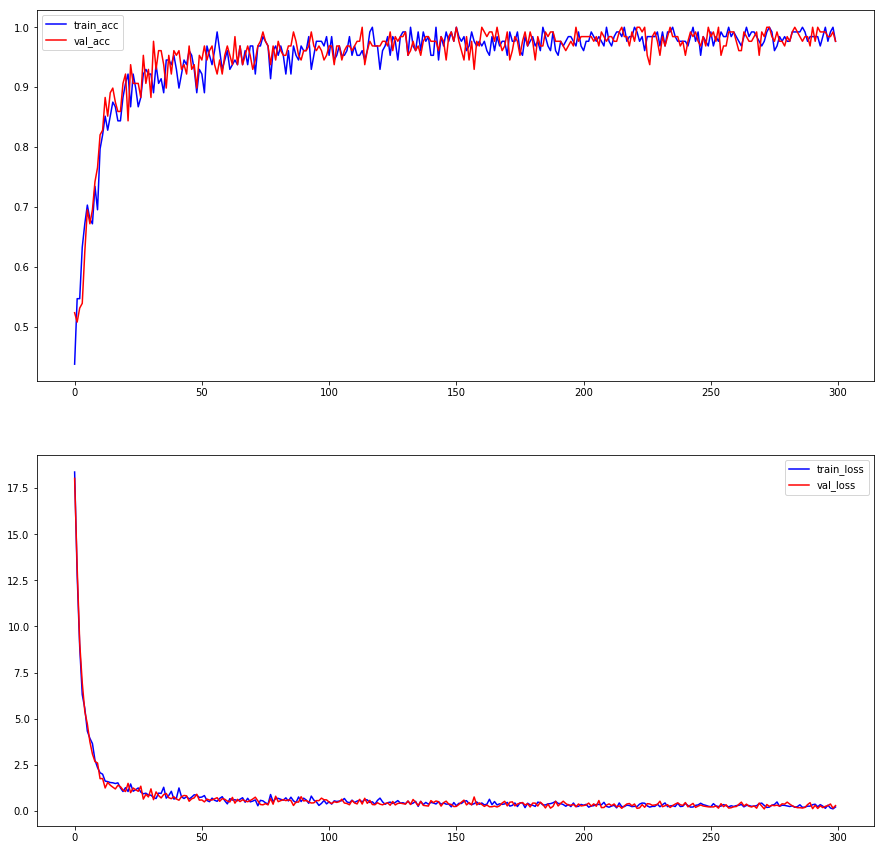

In [14]:
#Plot accuracy and loss
plt.figure(figsize=(15,15))
plt.subplot(211)
plt.plot(hist['train_acc'],'-b',label='train_acc')
plt.plot(hist['val_acc'],'-r',label='val_acc')
plt.legend()
plt.subplot(212)
plt.plot(hist['train_loss'],'-b',label='train_loss')
plt.plot(hist['val_loss'],'-r',label='val_loss')
plt.legend()

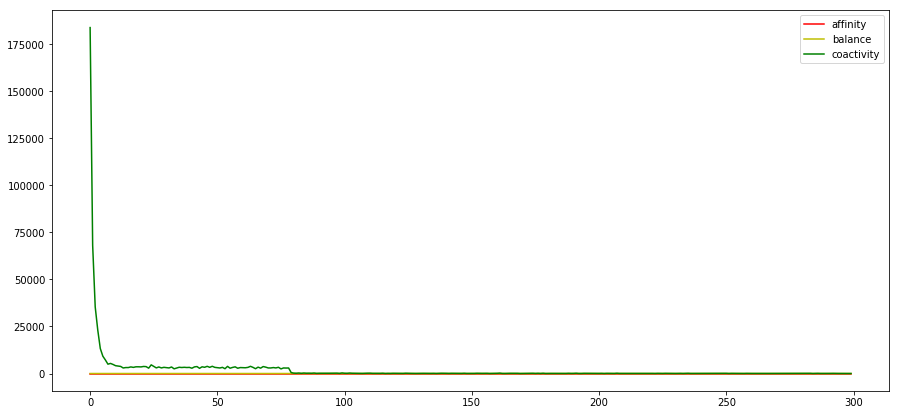

In [15]:
plt.figure(figsize=(15,7))
#plt.plot(hist['train_loss'],'-b',label='train_loss')
plt.plot(hist['affinity'],'-r',label='affinity')
plt.plot(np.subtract(1,hist['balance']),'-y',label='balance')
plt.plot(hist['coactivity'],'-g',label='coactivity')
plt.legend()

In [16]:
digitTrace = np.zeros((classCount*clustCount,784))
digitTraceCount = np.zeros((classCount*clustCount))
digitCount = np.zeros(10)

In [17]:
#sess.run(tf.global_variables_initializer())
for i in range(1000):
    tb = mnist.test.next_batch(1)
    digitCount[np.argmax(tb[1])]+=1
    testbatch = (tb[0],np.array([y[np.argmax(tb[1][j])] for j in range(len(tb[1]))]))
    smMat, acc = sess.run([softmaxMat,accuracy],feed_dict={x: testbatch[0], y_: testbatch[1]})
    ypred = softmaxMat.eval({x: testbatch[0], y_: testbatch[1]})
    digitTrace[np.argmax(ypred),:] += tb[0].ravel()
    digitTraceCount[np.argmax(ypred)] += 1

In [18]:
print(digitCount)
print(digitTraceCount)

[  90.  108.  103.  100.  107.   92.   91.  106.  103.  100.]
[  91.  110.  103.  104.  107.   90.   88.  101.  105.  101.]


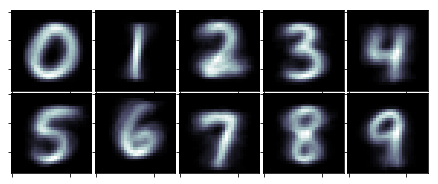

In [19]:
digitTrace = digitTrace/np.max(digitTrace)
f,ax=plt.subplots(nrows=classCount, ncols=clustCount, figsize=(1.5*clustCount,1.5*classCount))
gs = gridspec.GridSpec(classCount,clustCount)
gs.update(wspace=0.025, hspace=0.025)
f.subplots_adjust(wspace=0,hspace=0)
for i in range(digitTrace.shape[0]):
    sp = plt.subplot(gs[i])
    sp.set_xticklabels([])
    sp.set_yticklabels([])
    sp.set_aspect('equal')
    sp.grid = False
    plt.imshow(np.reshape(digitTrace[i,:],(28,28)),cmap='bone')

In [20]:
stepCount = len(hist['train_acc'])*100
with open('./trainlog.txt','ab') as f:
    f.write('lr: %g, batchsize: %i, steps: %i, thresh: %g, c1: %g, c2: %g, c3: %g, c4: %g, test_acc: %g, test_loss: %g\n'%
            (lr,batchSize,stepCount,tresh.eval(), cc1, cc2, cc3, cc4, test_acc, test_loss))

TypeError: a bytes-like object is required, not 'str'

## Clustering score

In [ ]:
tb = mnist.test.next_batch(10000)
#tb[0][:,:] = threshold(tb[0][:,:],threshmin=0.5,newval=0)
#tb[0][:,:] = threshold(tb[0][:,:],threshmax=0.49,newval=1)
testbatch = (tb[0],np.array([y[np.argmax(tb[1][j])>4] for j in range(len(tb[1]))]))
testFeed = {x: testbatch[0], y_: testbatch[1]}
ypred = softmaxMat.eval(testFeed)
ypred = ypred.reshape((tb[0].shape[0],clustCount*classCount))
ypred = tf.argmax(ypred,1).eval()
ylookup = [np.argmax(np.sum(tb[1][ypred==i],0)).astype('int32') for i in range(clustCount*classCount)]
yconverted = [ylookup[i] for i in ypred]
correct_prediction = tf.equal(yconverted, np.argmax(tb[1],1).astype('int32'))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).eval()
print('Clustering Accuracy: %g'%(accuracy))
print(ylookup)

## Compare it to k-means

In [ ]:
tb0 = [tb[0][np.argmax(tb[1],1)<5],tb[1][np.argmax(tb[1],1)<5]]
tb1 = [tb[0][np.argmax(tb[1],1)>4],tb[1][np.argmax(tb[1],1)>4]]
#<5
kmeans = KMeans(n_clusters=5)
km0_ypred = kmeans.fit_transform(tb0[0])
km0_ypred = np.argmax(km0_ypred,1)
km_ylookup = [np.argmax(np.sum(tb0[1][km0_ypred==i],0)).astype('int32') for i in range(clustCount)]
km_yconverted = [km_ylookup[i] for i in km0_ypred]
km_correct_prediction = tf.equal(km_yconverted, np.argmax(tb0[1],1).astype('int32'))
km0_accuracy = tf.reduce_mean(tf.cast(km_correct_prediction, tf.float32)).eval()
#>4
kmeans = KMeans(n_clusters=5)
km1_ypred = kmeans.fit_transform(tb1[0])
km1_ypred = np.argmax(km1_ypred,1)
km_ylookup = [np.argmax(np.sum(tb1[1][km1_ypred==i],0)).astype('int32') for i in range(clustCount)]
km_yconverted = [km_ylookup[i] for i in km1_ypred]
km_correct_prediction = tf.equal(km_yconverted, np.argmax(tb1[1],1).astype('int32'))
km1_accuracy = tf.reduce_mean(tf.cast(km_correct_prediction, tf.float32)).eval()
print('ACOL Accuracy: %g'%(accuracy))
print('KMeans Accuracy: %g'%((km0_accuracy+km1_accuracy)/2))

In [ ]:
#visualise kmeans
digitTrace = np.concatenate([[np.sum(tb0[0][km0_ypred==i,:],axis=0) for i in range(clustCount)],
                       [np.sum(tb1[0][km1_ypred==i,:],axis=0) for i in range(clustCount)]])
digitTrace = digitTrace/np.max(digitTrace)
f,ax=plt.subplots(nrows=classCount, ncols=clustCount, figsize=(1.5*clustCount,1.5*classCount))
gs = gridspec.GridSpec(classCount,clustCount)
gs.update(wspace=0.025, hspace=0.025)
f.subplots_adjust(wspace=0,hspace=0)
for i in range(digitTrace.shape[0]):
    sp = plt.subplot(gs[i])
    sp.set_xticklabels([])
    sp.set_yticklabels([])
    sp.set_aspect('equal')
    sp.grid = False
    plt.imshow(np.reshape(digitTrace[i,:],(28,28)),cmap='bone')